# 🚜 Predicting the Sale price of Bulldozers using ML

In this notebook, I'm going to go through an example machine learning project with the goal of predicting the sale price of bulldozers(um tipo de trator).

## 1. Definindo problema

> Como prever o preço de venda de um bulldozer, dando características e exemplos de vendas anteriores dos bulldozers

## 2. Dados

> Os dados foram baixados do Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

> Os datasets principais sao:
* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Validação (evaluation)

> A métrica usado da competiçao é a RMSLE(root mean squared log error) entre o preço atual e o preço previsto(comparaçao do preço atual e o preço previsto).

> Para mais evaluation: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Nota** O objetivo deste projeto é criar um modelo de ML que minimiza RMSLE.

## 4. Features (carcterísticas)

> Kaggle dispolibiliza o data dictionary detalhado das features do dataset: https://www.kaggle.com/c/bluebook-for-bulldozers/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
# train e validation sets
df = pd.read_csv("Dados/bluebook-for-bulldozers/TrainAndValid.csv", low_memory = False)

In [3]:
# SalePrice é a var de interece 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
# conferindo se há na's
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

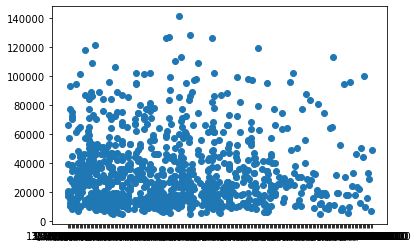

In [5]:
# plotando saledate e saleprice (saledate: time siries. saleprice: coluna alvo)
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [6]:
# por se tratar de muitos valores fica impossível ver os valores no eixo x. Vamos tentar com histogram

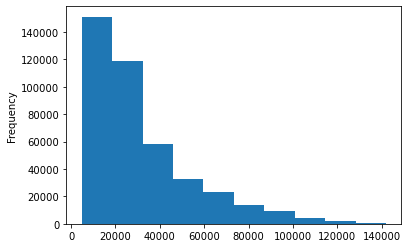

In [7]:
df.SalePrice.plot.hist();

In [8]:
# obsrvando o hist, vemos que a maior parte do SalePrice está abaixo dos 20mil dólares e vai diminuindo porque sao poucos vendidos acima dos 100000mil.

## Parsing dates

Quando trabalhamos com dados time series, queremos enriquecer os componentes 'time' e 'date' o máx possível.

Podemos fazer isso dizendo ao pandas qual das nossas cols tem datas e usar o parâmetro parse_dates. Isso fará com que
qualquer col de datas se tornem em objeto datatime, afim de deixar o eixo x mais legível.

In [9]:
df.saledate.dtype

dtype('O')

In [10]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

In [11]:
# digitando df.saledate.dtype retrona dtype('<M8[ns]') que é equivalente a df.saledate[:1000] que retorna dtypetime64.
# dtype('<M8[ns]') e dtypetime64 sao equivalentes.

In [12]:
# importando os dados, mas desta vez usando parse_dates
df = pd.read_csv("Dados/bluebook-for-bulldozers/TrainAndValid.csv", low_memory = False,
                parse_dates = ["saledate"])

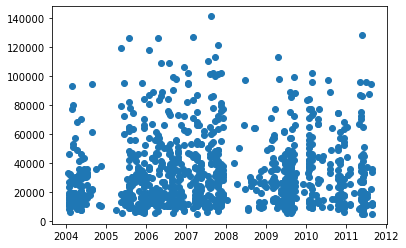

In [13]:
# vamos plotar
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [14]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# para ver todas as 53 cols usamos .T (T de transpose)
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


## Sort DataFrame by saledate (ordernando saledate)

Uma boa ideia para timeseries é colocar as datas em ordem.

In [16]:
# vamos ver as datas fora de ordem e depois colocar em ordem para melhorar a observaçao
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

In [17]:
# colocando em ordem crescente
df.sort_values(by = ["saledate"], inplace = True, ascending = True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [18]:
# vamos fazer uma cópia do dataframe original para manipular a cópia... se algo der errado teremos o original.
df_tmp = df.copy()

## Feature engineering
* vamos add  parametros datetime (d/m/a/) no dataframe para enriquecer a coluna `saledate`

In [19]:
# ex de como acessar as datas
df_tmp[:1].saledate

205615   1989-01-17
Name: saledate, dtype: datetime64[ns]

In [20]:
df_tmp[:1].saledate.dt.day

205615    17
Name: saledate, dtype: int64

In [21]:
df_tmp[:1].saledate.dt.year

205615    1989
Name: saledate, dtype: int64

In [22]:
# renomeando saledate com: ano, mês, dia, dia-da-semana, dia-do-ano,

In [23]:
df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

In [24]:
# como ficou
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [25]:
# Depois de enriquecer o dataframe com datetime features, podemos remover a col saledate.
df_tmp.drop("saledate", axis = 1, inplace = True)

In [26]:
# sem o saledate
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [27]:
# conferindo valores de diferentes cols...
# poderia ser qualquer uma. peguei 'estado'(state)
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## Convertendo strings em categories
 Uma maneira de transformar todos os dados em números é convertendo eles em pandas categories.
 
 Diferentes datatypes compativeis com pandas aqui: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.api.types.is_string_dtype.html

In [28]:
# relembrando o dataframe
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [29]:
# usando uma api.types para ver se é uma string ou do tipo numérica

pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [30]:
# Agora é construir um forloop para achar as cols que tenham strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [31]:
# O que aconteceu no código acima é que 'label' sao os nomes das cols e 'content' é o conteúdo das cols. 
# basicamente o forloop está mostrando todas as cols que contém datatype

In [32]:
# O que vai acontecer agora é tornar todas as strings value em category value
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [33]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [34]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

Agora que as categorias estao ordenadas, o que aconteceu aqui, apesar de estar parecendo que as strings estao em 
ordem alfabética (e realmente está), é que por tras de cada estado(state), pandas está tratando eles como números. Ex; Alabama=1, 
Alaska=2, Arizona=3...

In [35]:
# conferindo
#cat é para acessar acategoria
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [36]:
# Graças os pandas Categories agora temos uma meneira de acessar todos os dados em forma de números.
# Mas ainda temos um monte de dados faltantes

In [37]:
# conferindo dados faltantes... dividido por len(df_tmp) para ver em porcentagem
# os que estao zerados é que nao tem valores faltantes
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In [38]:
# antes de tratar os valores faltantes vou salvar os dados pre-processados
df_tmp.to_csv("Dados/bluebook-for-bulldozers/train_tmp.csv", index = False)

In [39]:
# Importando os dados que acabou de salvar
df_tmp = pd.read_csv("Dados/bluebook-for-bulldozers/train_tmp.csv", low_memory = False)

In [40]:
# conferindo
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [41]:
# relembrando que tem valores faltates
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Preenchendo valores faltantes

* preenchendo valores numéricos (numerical missing values)

In [42]:
# Quais cols sao numéricas
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [43]:
# confirindo uma das cols
df_tmp.YearMade

0         1974
1         1980
2         1978
3         1980
4         1984
          ... 
412693    2001
412694    2004
412695    2004
412696    1993
412697    1000
Name: YearMade, Length: 412698, dtype: int64

In [44]:
# conferindo qual das cols numéricas tem valores null
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [45]:
# preenchendo com a mediana
# usei a mediana por ser mais robusta

for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_tmp[label] = content.fillna(content.median())

In [46]:
# conferindo se ainda tem null values nas cols numericas
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [47]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                     0
YearMade                         0
MachineHoursCurrentMeter         0
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Preenchendo valores faltantes

* Preenchendo e transformando variáveis categóricas em números (categorical variables)

In [48]:
# conferindo cols nao numéricas
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


Quando transformamos uma col string em categórica, precisamos acessar um atributo chamado Codes, que nos dá valores númericos 
para todas as variaveis daquela col

In [49]:
# exemplo
pd.Categorical(df_tmp['state']).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [50]:
# transformando var categóricas em números e preenchendo as null(faltantes)
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # transformando as cat em num e add + 1
        df_tmp[label] = pd.Categorical(content).codes + 1

O +1 é para nao retornar nums negativos

In [51]:
# exemplo sem o +1
pd.Categorical(df_tmp["UsageBand"]).codes 
# pd.Categorical(df_tmp["UsageBand"]).codes + 1

# nota: por já ter rodado o essa linha antes, usageband nao vai retornar '[,-1]' como retornou da primeira vez

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [52]:
# conferindo
df_tmp.isna().sum()

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper    

## Modelando
* Poderia ter feito mais EDA, mas acho que já está bom. Vamos começar com model-driven EDA.
> Model-driven EDA, quer dizer que vou construir o modelo primeiro e ver as features mais importante e seguir daí. Mas, claro,
poderia ser do jeito 'tradicional': descobrir/determinar as features importantes primeiro e depois construir o modelo.

In [53]:
# importando random forest
from sklearn.ensemble import RandomForestRegressor

In [54]:
# conferindo 
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,1,8,6,0,0,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,0,0,0,4,2,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,1,8,6,0,0,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,0,0,0,4,2,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,1,6,5,0,0,1989,1,31,1,31


In [55]:
len(df_tmp)

412698

In [56]:
%%time
# construindo o modelo e dropando saleprice(é a var para previsao)

model = RandomForestRegressor(n_jobs = - 1, random_state = 42)

# ajustando o modelo
model.fit(df_tmp.drop("SalePrice", axis = 1), df_tmp["SalePrice"])

Wall time: 5min 35s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [57]:
# lembrando que estou tentando prever saleprice com base em todas as outras cols menos saleprice

In [58]:
# como o modelo se saiu
# procurando um valor perto de 1
model.score(df_tmp.drop("SalePrice", axis = 1), df_tmp["SalePrice"])

0.9875605620349615

**Pergunta:** Mas por que esse score nao é confiável? porque validamos com os mesmos dados. Precisa ser separado em train e valid set.
 * Se voltar no topo do notebook, em dados, acessando o link do kaggle, verá que Train, Valid e Test set estao disponíveis, mas aqui vamos separalos nós mesmos(eu vou fazer nesse caso, mas os dados já separados no kaggle.

## Separando os dados em Train/Validation sets

In [59]:
# conferindo os dados
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,1,8,6,0,0,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,0,0,0,4,2,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,1,8,6,0,0,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,0,0,0,4,2,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,1,6,5,0,0,1989,1,31,1,31


In [60]:
# vamos usar saleyear para valid set
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

**O set de validaçao será separado com dados de 2012. 
Set de treino serao os dados até 2011.**

Os dados de teste estao em dados separados no kaggle (consultar o link do começo ou nos dados do notebook que salvei).

In [61]:
# conferindo
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [62]:
# separando os dados em Train/valid sets
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

# quantas amostras tem em cada
len(df_val), len(df_train)

(11573, 401125)

In [63]:
# separando em X e y
X_train , y_train = df_train.drop("SalePrice", axis = 1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis = 1), df_val.SalePrice

# confirindo o formato de X e y train, e X e y valid
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 56), (401125,), (11573, 56), (11573,))

In [64]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

## Construindo uma evaluation function

* Vamos criar a nossa propria funçao de validaçao. A competiçao pede RMSLE(root mean squared log error).
> O motivo é que vamos ter(talvez) que rodar em multiplos experimentos em diversos modelos de ML e valida-los.
Por isso vamos contruir em uma funçao para usarmos varias vezes sem ter que ficar nos repetindo

In [65]:
# Criando a funçao
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calcula root mean squared log error entre prediçoes e true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# criando a funçao para avaliar o modelo em alguns níveis diferentes
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

In [66]:
# O que foi feito acima? criamos uma evaluation function de acordo com o que foi pedido nesse projeto(rmsle);
# depois criamos uma outra pequena funçao pra ajudar em várias outras metricas, e fará algumas previsoes usando nosso modelo;
# depois comparar essas previsoes em diversos outros campos: mae, rmsle, e no coeficiente de determinaçao (R^2).

## Reduzindo dados
#### Testando o medelo num subset (pra melhorar hyperparametros)

In [67]:
# repetir este modelo demoraria demais (mais ou menos 5 á 6 min)

# %%time
# model = RandomForestRegressor(n_jobs = - 1, random_state = 42)

# model.fit(X_train, y_train)

In [68]:
# porque X_train é muito grande
len(X_train)

401125

In [69]:
# A soluçao é aumentar a velocidade do/s experimentos

In [70]:
# Mudando o valor de max_samples
model = RandomForestRegressor(n_jobs = - 1, random_state = 42, max_samples = 10000)

In [71]:
%%time
# reduzindo o num max de amostras que cada estimativa pode ver; melhora o tempo de treinamento(esse é a hipótese)

model.fit(X_train, y_train)

Wall time: 11.1 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [72]:
# testando score function
show_scores(model)

{'Training MAE': 5563.72867258336,
 'Valid MAE': 7168.9377352458305,
 'Training RMSLE': 0.2578202020674087,
 'Valid RMSLE': 0.2929702627803096,
 'Training R^2': 0.8605936890077203,
 'Valid R^2': 0.8322757239076886}

In [73]:
# validMAE um pouco mais alto que trainingMAE, significa que nao tem overfitting
# training e valid R^2 estao muito ruims porque foi trainado com subset com 10000 max_samples e nao com  os 401125

In [74]:
# validRMSLE que parace por aqui e comparando com a pontuaçao do kaggle estariamos no top 100 

## Melhorando hyperparametros com RandomizedSearchCV

RandomizedSearchCV basicamente cria um parâmetro de distribuiçao(parece um dicionário), vai pegar(estimar) o modelo e procurar no parâmetro de distribuiçao pelo melhor hyperparametrs para o modelo.

In [75]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# diferentes randomforestregressor hyperparametros
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = - 1, random_state = 42),
                              param_distributions = rf_grid, n_iter = 30,
                              cv = 5, verbose = True)

# fit randomizedsearchcv model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Wall time: 6min 26s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=30,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

Entao, o randomizedsearchcv vai pegar 30 combinaçoes diferentes de rf_grid, atribuir ao randomforestregressor, colocar
nos dados de treino, (com apenas 10000 amostras), e nos dizer qual o melhor parâmetro.

Em n_iter coloquei igual a 30, mas pode ser 100ex, cv(cross validation) pode ser mais que 5; mas pode demorar muito, e a ideia do experimento é ele ser rápido. Claro que se a gente tiver mais tempo e mais ram colocamos cem em n_iter.

In [76]:
# Fitting 5 folds for each of 30 candidates, totalling 150 fits. 150 melhores parâmetros foram encontrados
# demorando quase 2min a mais que o primeiro modelo.

In [77]:
# o melhor modelo hyperparameters encontrado
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 16,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [78]:
# avaliando RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 6219.794967860142,
 'Valid MAE': 7583.376059768102,
 'Training RMSLE': 0.2818626242456041,
 'Valid RMSLE': 0.30720799144240957,
 'Training R^2': 0.827614293647884,
 'Valid R^2': 0.8112767627337292}

In [79]:
%%time
# vou refazer rs_model (vou chamar de rs_model2) só que agora com n_iter = 100
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = - 1, random_state = 42),
                              param_distributions = rf_grid, n_iter = 100,
                              cv = 5, verbose = True)

# fit randomizedsearchcv model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 20min 14s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [80]:
# obs: esqueci de mudar para: rs_model2. vamos em frente!

In [81]:
# o melhor modelo hyperparameters encontrado
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 8,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

## Treinando o modelo com o melhor hyperparâmetro

* Foi encontrado depois de 100 interaçoes do RandomizedSearchCV.
* Lembrando que ainda vamos usar o test.csv.

In [82]:
%%time

# hyperparâmetro ideial
# max_samples=None para usar o max de amostras possível

ideal_model = RandomForestRegressor(n_estimators = 70,
                                    min_samples_split = 2,
                                    min_samples_leaf = 1,
                                    max_samples = None,
                                    max_features = 'auto',
                                    max_depth = None,
                                    n_jobs = - 1,
                                    random_state = 42)

# fit ideal_model
ideal_model.fit(X_train, y_train)

Wall time: 3min 50s


RandomForestRegressor(n_estimators=70, n_jobs=-1, random_state=42)

In [83]:
# pode demorar mais ou menos, dependendo das cofiguraçoes do pc(meu: 10gb Ram, processador i5, e deve ter mais de 8 anos de uso já)

In [84]:
# avaliando o modelo (treinado com todos os dados) 
show_scores(ideal_model)

{'Training MAE': 1589.7130714508303,
 'Valid MAE': 6134.1224006616385,
 'Training RMSLE': 0.0850542326735335,
 'Valid RMSLE': 0.2559668380959921,
 'Training R^2': 0.9872355070140592,
 'Valid R^2': 0.8720228658369289}

In [85]:
# avaliando RandomizedSearchCV model (treinado com 10,000 amostras)
show_scores(rs_model)

{'Training MAE': 6077.4974858622445,
 'Valid MAE': 7516.058188942323,
 'Training RMSLE': 0.27587321167286316,
 'Valid RMSLE': 0.3046344700471786,
 'Training R^2': 0.8345271895556108,
 'Valid R^2': 0.814086162268026}

In [86]:
# pequena, mas considerável melhora no valid RMSLE que é o que o kaggle pede, mas da pra melhorar ainda mais se quiser.
# (vou tentar melhor depois). vamos em frente!

## Fazendo previsões com Test.csv

In [87]:
# Importando dados de teste
df_test = pd.read_csv("Dados/bluebook-for-bulldozers/Test.csv", low_memory = False, parse_dates = ["saledate"])

df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [88]:
# A diferença do test.csv é que nao tem a col saleprice que é o que queremos prever

#### Antes de fazer a previsao presisamos fazer algumas manipulações como: tratar na's, certificar que os dados são numéricos. 
#### Para que a previsao seja feita o test.csv precisa estar no mesmo formato em que o modelo foi treinado.

In [89]:
# verificando tipo de dados categóricos
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

In [90]:
# verificando na's
df_test.isnull().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

## Pre-processando os dados
* Colocando o test set no mesmo formato que o train set.
 > Usarei a mesma funçao de train set e fazer a mesma coisa no test set.

In [91]:
def preprocess_data(df):
    """
    Executar transformaçoes em df a retornar a df transformada.
    """
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis = 1, inplace = True)
    
    # preenchendo as linhas(rows) com a mediana
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label] = content.fillna(content.median())
            
        # Preenchendo dados categóricos faltantes
        if not pd.api.types.is_numeric_dtype(content):
            # transformando as cat em num e add + 1
            df[label] = pd.Categorical(content).codes + 1
    
    return df

In [92]:
# Processando dados de test
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,0,0,0,0,0,2012,5,3,3,124
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,0,0,0,3,2,2012,5,10,3,131
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,0,0,0,0,0,2012,5,10,3,131
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,0,0,0,0,0,2012,5,10,3,131
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,1,4,5,0,0,2012,5,10,3,131


In [93]:
# comparando com X_train pra ver se estao com mesmo num de cols e rows
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,1,8,6,0,0,1989,1,17,1,17
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,0,0,0,4,2,1989,1,31,1,31
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,1,8,6,0,0,1989,1,31,1,31
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,0,0,0,4,2,1989,1,31,1,31
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,1,6,5,0,0,1989,1,31,1,31


#### Agora que o dataframe de test tem as mesmas features que o train dataframe, podemos fazer as previsoes.

In [94]:
# Fazendo previsoes
test_preds = ideal_model.predict(df_test)

In [95]:
test_preds

array([20441.42857143, 17435.        , 46385.71428571, ...,
       12192.14285714, 17592.85714286, 30760.71428571])

#### Agora a previsao precisa ser no formato que o Kaggle está pedindo:
https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview/evaluation

In [96]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds

df_preds

,SalesID,SalesPrice
0,1227829,20441.428571
1,1227844,17435.000000
2,1227847,46385.714286
3,1227848,80200.000000
4,1227863,53932.857143
...,...,...
12452,6643171,49542.857143
12453,6643173,11357.142857
12454,6643184,12192.142857
12455,6643186,17592.857143


In [97]:
# Exportando dados da previsao
df_preds.to_csv("Dados/bluebook-for-bulldozers/test_previsoes.csv", index = False)

## Feature importance
Feature importance tenta descobrir qual dos diferentes atributos do dataset sao mais importantes quando está prevendo a var alvo (SalePrice)

In [100]:
# Encontrando a característca mais importantes
ideal_model.feature_importances_

array([4.99234588e-02, 1.65856838e-02, 3.26638232e-02, 4.51122626e-04,
       4.52154291e-03, 2.61384604e-01, 3.40740361e-03, 1.26136492e-03,
       2.00076293e-02, 7.81590100e-02, 5.24335744e-02, 4.81972178e-03,
       4.22821682e-03, 2.30266618e-01, 3.96404814e-02, 8.93121210e-03,
       2.67470196e-04, 2.40213961e-04, 1.71393861e-03, 8.77467920e-03,
       4.36272860e-04, 4.27402645e-05, 5.86946086e-04, 1.81008758e-04,
       1.63997654e-03, 2.78834573e-05, 1.30865569e-03, 7.46900247e-03,
       6.11262007e-04, 5.00995175e-04, 4.42478103e-03, 1.86781126e-03,
       2.37185193e-03, 7.34692281e-03, 1.76366456e-03, 2.05400564e-03,
       1.07872362e-03, 2.99862358e-02, 1.26164392e-05, 5.19592093e-06,
       2.01682091e-04, 1.14867626e-03, 1.34631618e-03, 7.87402252e-04,
       2.66840342e-04, 5.09771603e-04, 3.92895794e-04, 1.79620834e-03,
       1.11838644e-03, 2.21572000e-04, 2.71248267e-04, 7.64193059e-02,
       3.37971685e-03, 9.27854222e-03, 4.60254254e-03, 1.48605707e-02])

In [111]:
# fazer uma funçao para plotar as features ao invez de procurar uma por uma

def plot_features(columns, importances, n = 20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending = False)
          .reset_index(drop = True))
    
    # plotar o dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("features")
    ax.set_xlabel("feature importance")
    ax.invert_yaxis()

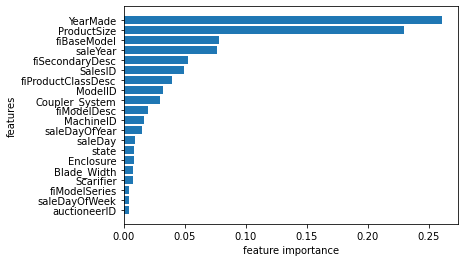

In [112]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [ ]:
# podem ser considerados features importantes as quatro primeiras da tabela ou apenas YearMade e ProductSize

Pode ser feita uma reunião com a equipe de vendas e saber essas features estao de acordo com o que a empresa acha importante.
* O modelo pode ser otimizado melhor agora que se sabe as características mais importantes.
* O score RMSLE pode ser melhorado e alcançar uma melhor posiçao na competiçao do Kaggle(essa competiçao é de 2012, mas vale se desafiar).
* Outros modelos de machine learning podem ser usados no dataset para comparar com o modelo atual, como: CatBoost.ai ou XGBoost.ai(opcionais).
* Saber mais: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

#### Nota.
Se voce chegou até aqui e viu que eu nao mexi mais neste projeto é porque vou/estarei trabalhando em outros projetos, mas vou usar para pesquisas/referência. Em algum momento eu voltarei nele para me desafiar a melhora-lo.
Entender que nao precisa (em alguns casos) ficar sendo repetitivo e saber que muita coisa pode ser melhorada. 

Em fim, foi muito divertido (da hora!😅) trabalhar/estudar neste projeto! 

#peaceout!

In [ ]:
# espero que eu continue entendedo esses codgos quando voltar aqui! 